# Importing Touchstone Files from HFSS

In this notebook, I import S-parameters from a Touchstone file. This file was generated by an HFSS simulation of a simple waveguide:

![title](data/simple-waveguide.png)

This waveguide is WR2.8 with a length of 5.875 mm (approximately 5 wavelengths long).

We will use two different packages, [SciKit-RF](https://scikit-rf-web.readthedocs.io/) and [RF-Tools](https://github.com/garrettj403/RF-tools), to import this file and compare the results.

**Notes on exporting S-parameters from HFSS:**

- In the "Wave Port" menu, set the "Characteristic Impedance (Zo)" to "Zwave" (not "Zpi" which is the default).

- To export:

   - Results > Solution Data > Export > Export Matrix Data...
   
   - Do not override the solution renormalization.

   - Include gamma and impedance in the comments.

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import scipy.constants as sc
import skrf  # SciKit-RF
import rftools as rf  # RF-Tools

# https://github.com/garrettj403/SciencePlots
plt.style.use(['science', 'notebook'])

**Note:** We can use RF-tools to get the properties of the WR2.8 waveguide:

In [3]:
!waveguide WR-2.8


	Rectangular Waveguide: WR-2.8
	--------------------------------------------------
	a               =   0.711		[mm]          
	b               =   0.356		[mm]          

	low freq.       = 263.457		[GHz]         
	mid freq.       = 330.901		[GHz]         
	high freq.      = 398.346		[GHz]         

	cutoff TE10     = 210.765		[GHz]         
	cutoff TE20     = 421.530		[GHz]         
	cutoff TE01     = 421.530		[GHz]         
	cutoff TE/TM11  = 471.285		[GHz]         

	-> at 330.9 GHz
	wavelength      =   1.175		[mm]          
	impedance       = 488.682		[ohms]        



# First using SciKit-RF

In [4]:
network1 = skrf.Network('data/simple-waveguide.s2p')

### Plot S-parameters

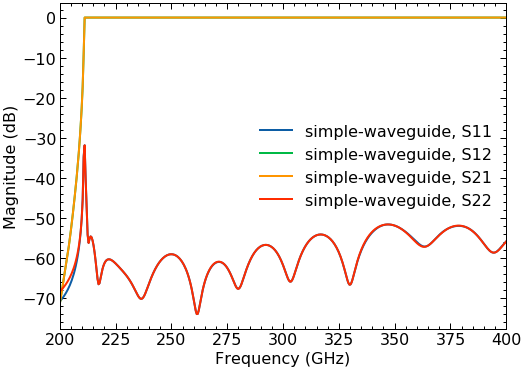

In [5]:
network1.plot_s_db()

### Plot port impedance

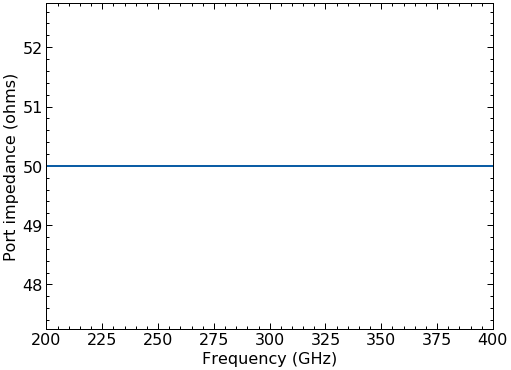

In [6]:
fig, ax = plt.subplots()
ax.plot(network1.f / sc.giga, network1.z0[:,0].real)
ax.set(xlabel='Frequency (GHz)', ylabel='Port impedance (ohms)', xlim=[200, 400]);

**Note:** The port impedance was not loaded! SciKit-RF assumes $Z_0 = 50~\Omega$!

# Now with RF-tools

In [7]:
network2 = rf.Network('data/simple-waveguide.s2p')

### Plot S-parameters

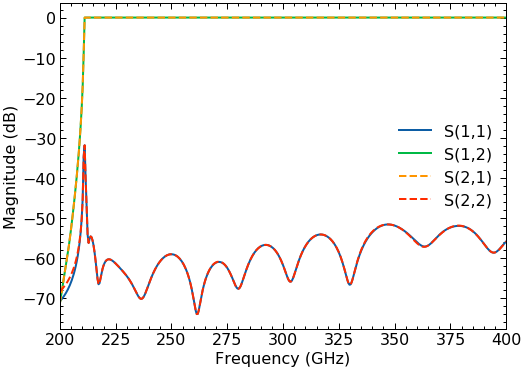

In [8]:
fig, ax = plt.subplots()
network2.plot_sparam(ax=ax)
ax.set(xlim=[200, 400]);

### Plot port impedance

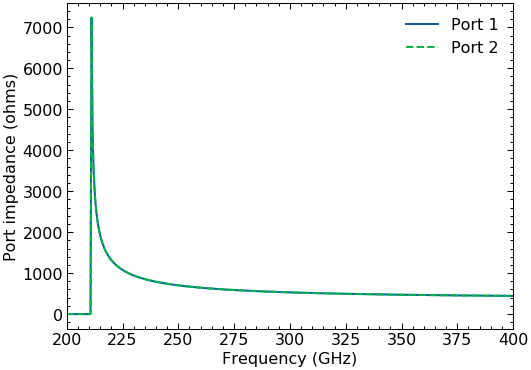

In [9]:
fig, ax = plt.subplots()
ax.plot(network2.f, network2.get_z0('1'), label='Port 1')
ax.plot(network2.f, network2.get_z0('2'), ls='--', label='Port 2')
ax.set(xlabel='Frequency (GHz)', ylabel='Port impedance (ohms)', xlim=[200, 400])
ax.legend();

Port impedance is imported properly!

# Compare HFSS to theory

In [10]:
# Build theoretical model with RF-tools
wg = rf.RectangularWaveguide(0.711*sc.milli, 0.356*sc.milli, verbose=False)

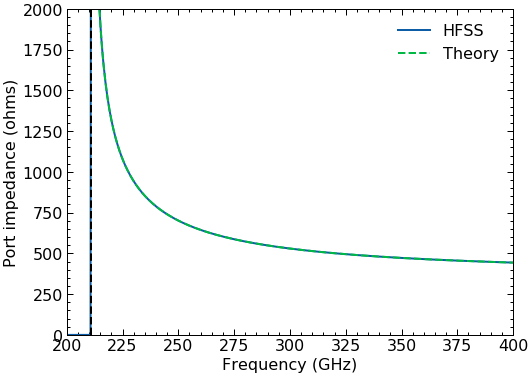

In [12]:
fig, ax = plt.subplots()
ax.plot(network2.f, network2.get_z0('1'), label='HFSS')
ax.plot(network2.f, wg.impedance(network2.f * sc.giga, 'TE10'), label='Theory', ls='--')
ax.axvline(wg.fc / sc.giga, ls='--', c='k')
ax.set(xlabel='Frequency (GHz)', ylabel='Port impedance (ohms)', ylim=[0, 2000], xlim=[200, 400])
plt.legend();

Correctly predicts the cutoff frequency and the characteristic impedance!